# EKS with distance constraints

In [7]:
import os
import numpy as np
import pandas as pd
import sys
from eks.utils import *
from eks.multiview_pca_fish import *
from eks.multiview_pca_smoother import pca, ensemble_kalman_smoother_multi_cam
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm


In [8]:
camera_names = ['main', 'top', 'right']
keypoint_ensemble_list = ['mid','fork','chin_base']
tracker_name = 'heatmap_mhcrnn_tracker'
num_cameras = len(camera_names)
labeled_data = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/mirror-fish/CollectedData_new.csv", header = [1,2])

#%% set distance constraint projection for a few q's in keypoint_ensemble_list


camkeys = ["_main","_top","_right"]
# flatten columns
labeled_data.columns = ['_'.join(tup).rstrip('_') for tup in labeled_data.columns.values]
mask = []
for keys in keypoint_ensemble_list:
    for cam in camkeys:
        for coord in ["_x", "_y"]:
            mask.append(keys+cam+coord)
            

In [9]:
labeled_data.head()

,bodyparts_coords,head_main_x,head_main_y,chin_base_main_x,chin_base_main_y,chin1_4_main_x,chin1_4_main_y,chin_half_main_x,chin_half_main_y,chin3_4_main_x,...,tail_neck_right_x,tail_neck_right_y,dorsal_right_x,dorsal_right_y,anal_right_x,anal_right_y,caudal_d_right_x,caudal_d_right_y,caudal_v_right_x,caudal_v_right_y
0,labeled-data/20210126_Sean/img001058.png,284.0,324.5,292.5,353.5,292.0,356.5,290.0,358.5,286.5,...,429.5,255.5,413.5,250.5,426.0,289.0,441.5,227.0,442.5,246.0
1,labeled-data/20210126_Sean/img001503.png,304.5,322.0,304.5,349.5,304.0,354.0,303.0,357.5,303.0,...,445.0,276.5,431.0,267.0,448.0,310.0,437.0,242.5,439.0,257.5
2,labeled-data/20210126_Sean/img014428.png,290.5,328.5,285.0,362.0,284.5,366.0,289.0,366.5,293.0,...,413.5,259.5,387.5,258.0,434.0,284.5,418.5,224.5,430.5,244.5
3,labeled-data/20210126_Sean/img015407.png,418.5,347.0,453.5,364.5,455.5,367.5,458.5,372.0,460.5,...,426.0,327.0,440.5,307.5,NaN,NaN,421.0,310.0,NaN,NaN
4,labeled-data/20210126_Sean/img019268.png,319.0,325.5,302.0,340.0,301.5,343.5,301.5,347.0,303.0,...,472.0,288.5,449.5,269.5,462.5,324.0,NaN,NaN,NaN,NaN


In [10]:
img197707_id = labeled_data.loc[['labeled-data/20210204_Quin/img197707.png' in s for s in labeled_data.bodyparts_coords]].index[0]

## 3D projection minimising limb distance variance

In [11]:
markers_list = labeled_data.reset_index()[mask]
# Ensemble
scaled_dict = []
good_frames_dict = []
good_preds_dict = []
ensemble_vars_dict = []
means_camera_dict = []
markers_list_cameras  = []
            
n = len(markers_list)
nkeys = len(keypoint_ensemble_list)
num_cameras = len(camkeys)
y_obs = np.empty((nkeys, n, 2*num_cameras))
q = np.empty((nkeys, n, 3))
for j, keypoint_ensemble in enumerate(keypoint_ensemble_list):
    markers_list_cameras = [[] for i in range(num_cameras)]
    for i,cam in enumerate(camkeys):
        tmp = []

        for m in markers_list.keys():
            if cam in m and keypoint_ensemble in m:
                tmp.append(markers_list[m])
    
        markers_list_cameras[i].append(pd.concat(tmp, axis=1))

    
    y = np.asarray(markers_list_cameras).reshape(n, nkeys*2)
    
    # fill nans by median value 
    col_mean = np.nanmedian(y, axis=0)
    inds = np.where(np.isnan(y))
    y[inds] = np.take(col_mean, inds[1])
    
    # scale 
    from sklearn.preprocessing import scale
    scaled_y = scale(y)
    # get PCA 
    labeled_pca, labeled_var = pca(y, 3)
    
    q[j,:,:] = labeled_pca.transform(scaled_y)
    y_obs[j,:,:] = y


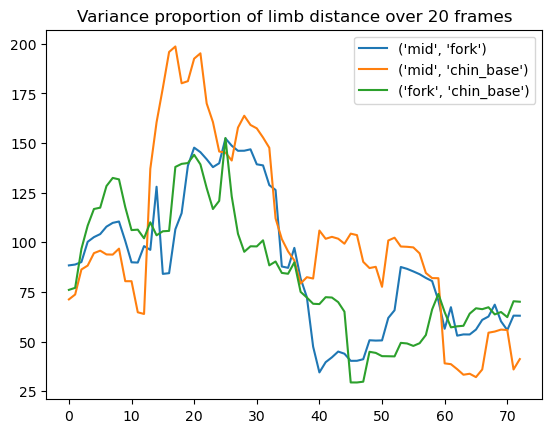

In [12]:
# Initialize L as a lower triangular matrix
n = 3  # Define the size of L
L_initial = np.tril(np.eye(n)).flatten()
import plotly.io as pio
import plotly.express as px
pio.renderers.default='browser'

L = find_linear_transformation(q, L_initial)

pair_list = pairwise(keypoint_ensemble_list)
v = variance_limb_plot(20, L, q, pair_list, keypoint_ensemble_list)

pair_list = [('mid', 'chin_base'),('chin_base','fork')]
D = get_3d_distance_loss(q, L, keypoint_ensemble_list,pair_list, 3)




In [13]:
D_ij = D[img197707_id,:,:]
D_ij

array([[   0.        ,    0.        , 1668.35033174],
       [   0.        ,    0.        ,  498.79481527],
       [1668.35033174,  498.79481527,    0.        ]])

filtering ...
done filtering
smoothing mid...
done smoothing
smoothing fork...
done smoothing
smoothing chin_base...
done smoothing
done filtering
smoothing mid...
done smoothing
smoothing fork...
done smoothing
smoothing chin_base...
done smoothing
done filtering
smoothing mid...
done smoothing
smoothing fork...
done smoothing
smoothing chin_base...
done smoothing
done filtering
smoothing mid...
done smoothing
smoothing fork...
done smoothing
smoothing chin_base...
done smoothing
done filtering
smoothing mid...
done smoothing
smoothing fork...
done smoothing
smoothing chin_base...
done smoothing
done filtering
smoothing mid...
done smoothing
smoothing fork...
done smoothing
smoothing chin_base...
done smoothing


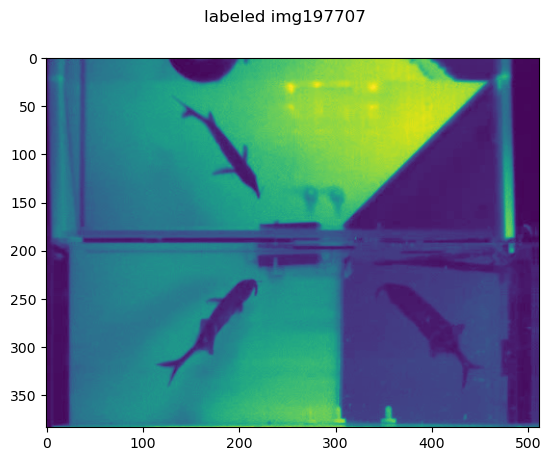

In [32]:
mu = [0,0.01,0.1, 0.2, 0.5, 0.10]
c = [('fork','mid'),('chin_base','fork'),('mid','chin_base')]
folder = "/eks_opti"
operator = "/20210204_Quin/"
name = "img197707"

baseline = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks"+operator+name+".csv", header=[ 1, 2],index_col=0)
#new = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions"+folder+operator+name, header=[ 1, 2], index_col=0)
baseline0 = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks"+operator+name+".csv", header=[0, 1, 2],index_col=0)


# NOTE! replace this path with an absolute path where you want to save EKS outputs
eks_save_dir = '/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions/eks_opti/'

# path for prediction csvs
file_path = '/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions'

# NOTE! replace these paths with the absolute paths to prediction csvs on your local computer
model_dirs = [
    file_path+"/network_0",
    file_path+"/network_1",
    file_path+"/network_2",
    file_path+"/network_3",
    file_path+"/network_4",
]


#    'head', 'chin_base', 'chin1_4', 'chin_half','chin3_4', 'chin_tip', 'mid', 'fork',
#   'stripeA', 'stripeP', 'tail_neck', 'dorsal', 'anal', 'caudal_d', 'caudal_v',

image_path = "/Users/clairehe/Documents/GitHub/eks/data/mirror-fish/labeled-data"
im = plt.imread(image_path+operator+name+".png")
plt.imshow(im)
plt.suptitle("labeled "+name)


session = '20210204_Quin'
frame = 'img197707.csv'
smooth_param = 0.01
quantile_keep_pca = 50
# Get markers list from networks
markers_list = []
for model_dir in model_dirs:
    csv_file = os.path.join(model_dir, session, frame)
    df_tmp = pd.read_csv(csv_file, header=[0, 1, 2], index_col=0)
    keypoint_names = [l[1] for l in df_tmp.columns[::3]]
    markers_tmp = convert_lp_dlc(df_tmp, keypoint_names, model_name=tracker_name)
    markers_list.append(markers_tmp)

# Ensemble
scaled_dict = []
good_frames_dict = []
good_preds_dict = []
ensemble_vars_dict = []
means_camera_dict = []
for n, keypoint_ensemble in enumerate(keypoint_ensemble_list):
    markers_list_cameras = [[] for i in range(num_cameras)]
    for m in markers_list:
        for camera in range(num_cameras):
            markers_list_cameras[camera].append(
                m[[key for key in m.keys() 
                   if camera_names[camera] in key 
                   and 'likelihood' not in key 
                   and keypoint_ensemble in key]
                 ]
            )
    # ENSEMBLING PER KEYPOINTS
    scaled_ensemble_preds, good_frames, good_scaled_ensemble_preds,ensemble_vars,means_camera = ensembling_multiview(markers_list_cameras, keypoint_ensemble, smooth_param, quantile_keep_pca, camera_names, plot=True)
    scaled_dict.append(scaled_ensemble_preds)
    good_frames_dict.append(good_frames)
    good_preds_dict.append(good_scaled_ensemble_preds)
    ensemble_vars_dict.append(ensemble_vars)
    means_camera_dict.append(means_camera)
ensemble_vars = np.array(ensemble_vars_dict)


stacked_preds,ensemble_pca,ensemble_ex_var,ensemble_pcs,good_ensemble_pcs =  multiview_pca_bodyparts(scaled_dict,good_preds_dict,good_frames_dict)

y_obs = np.asarray(stacked_preds)

#compute center of mass
#latent variables (observed)
good_z_t_obs = good_ensemble_pcs #latent variables - true 3D pca

n, T, v = y_obs.shape

##### Set values for kalman filter #####
m0 = np.asarray([0.0, 0.0, 0.0]) # initial state: mean
S0 = np.zeros((nkeys,m0.shape[0], m0.shape[0] ))
d_t = {key: None for key in range(nkeys)}
# need different variance for each bodyparts 
for k in range(n):
    S0[k,:,:] =  np.asarray([[np.var(good_z_t_obs[k][:,0]), 0.0, 0.0], [0.0, np.var(good_z_t_obs[k][:,1]), 0.0], [0.0, 0.0, np.var(good_z_t_obs[k][:,2])]]) # diagonal: var
    d_t[k] = good_z_t_obs[k][1:] - good_z_t_obs[k][:-1]

    Q = smooth_param*np.cov(d_t[k].T)

A = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) #state-transition matrix,
# Q = np.asarray([[10.0, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]) #state covariance matrix?????


C = ensemble_pca.components_.T # Measurement function is inverse transform of PCA
R = np.eye(ensemble_pca.components_.shape[1]) # placeholder diagonal matrix for ensemble variance

all_mu = {0:None, 1: None}
print(f"filtering ...")
for i in range(len(mu)):
    mfc, Vfc, Sc  = filtering_pass_with_constraint(y_obs, m0, S0, C, R, A, Q,ensemble_vars, D_ij, L,keypoint_ensemble_list, constrained_keypoints_graph=c, mu=mu[i])

    # Do the smoothing step
    print("done filtering")
    y_m_filt = {key: None for key in range(n)}
    y_v_filt = {key: None for key in range(n)}
    y_m_smooth = {key: None for key in range(n)}
    y_v_smooth = {key: None for key in range(n)}
    ms = {key: None for key in range(n)}
    Vs = {key: None for key in range(n)}
    for k in range(n):
        y_m_filt[k] = np.dot(C, mfc[k].T).T
        y_v_filt[k] = np.swapaxes(np.dot(C, np.dot(Vfc[k], C.T)), 0, 1)
        print(f"smoothing {keypoint_ensemble_list[k]}...")
        ms[k], Vs[k], _ = smooth_backward(y_obs[k], mfc[k], Vfc[k], Sc[k], A, Q, C)
        print("done smoothing")

        # Smoothed posterior over yb
        y_m_smooth[k] = np.dot(C, ms[k].T).T
        y_v_smooth[k] = np.swapaxes(np.dot(C, np.dot(Vs[k], C.T)), 0, 1)

    ncams = len(camkeys)
    camera_dfs = {}
    camera_indices = []
    for camera in range(ncams):
        camera_indices.append([camera*2, camera*2+1])

    for camera, camera_name in enumerate(camera_names):
        key_df = []
        for k, keypoint_ensemble in enumerate(keypoint_ensemble_list):
            pdindex = make_dlc_pandas_index([keypoint_ensemble])
            var = np.empty(y_m_smooth[k].T[camera_indices[camera][0]].shape)
            var[:] = np.nan
            pred_arr = pd.DataFrame(np.vstack([
                y_m_smooth[k].T[camera_indices[camera][0]] + means_camera[camera_indices[camera][0]],
                y_m_smooth[k].T[camera_indices[camera][1]] + means_camera[camera_indices[camera][1]],
                var,
            ]).T, columns = pdindex)
            key_df.append(pred_arr)
        camera_dfs[camera_name + '_df'] = pd.concat(key_df,axis=1)

    all_mu[i] = camera_dfs








In [33]:
camkeys = ['main', 'top', 'right']
camkeys, keypoint_ensemble_list

(['main', 'top', 'right'], ['mid', 'fork', 'chin_base'])

In [34]:
means_camera

[214.9575923039363,
 234.17564802903397,
 217.74507082425632,
 134.5910186767578,
 355.2393282376803,
 240.33055290809045]

In [35]:
ncams = len(camkeys)
camera_dfs = {}
camera_indices = []
for camera in range(ncams):
    camera_indices.append([camera*2, camera*2+1])

for camera, camera_name in enumerate(camera_names):
    key_df = []
    for k, keypoint_ensemble in enumerate(keypoint_ensemble_list):
        pdindex = make_dlc_pandas_index([keypoint_ensemble])
        var = np.empty(y_m_smooth[k].T[camera_indices[camera][0]].shape)
        var[:] = np.nan
        pred_arr = pd.DataFrame(np.vstack([
            y_m_smooth[k].T[camera_indices[camera][0]] + means_camera[camera_indices[camera][0]],
            y_m_smooth[k].T[camera_indices[camera][1]] + means_camera[camera_indices[camera][1]],
            var,
        ]).T, columns = pdindex)
        key_df.append(pred_arr)
    camera_dfs[camera_name + '_df'] = pd.concat(key_df,axis=1)
    



In [36]:
#plt.plot(all_mu[0]['{}_df'.format('top')]['ensemble-kalman_tracker']['mid']["x"], color='black', label = 'distance constrained')

In [37]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('constrained_fish.p', 'wb') as fp:
    pickle.dump(camera_dfs, fp, protocol=pickle.HIGHEST_PROTOCOL)

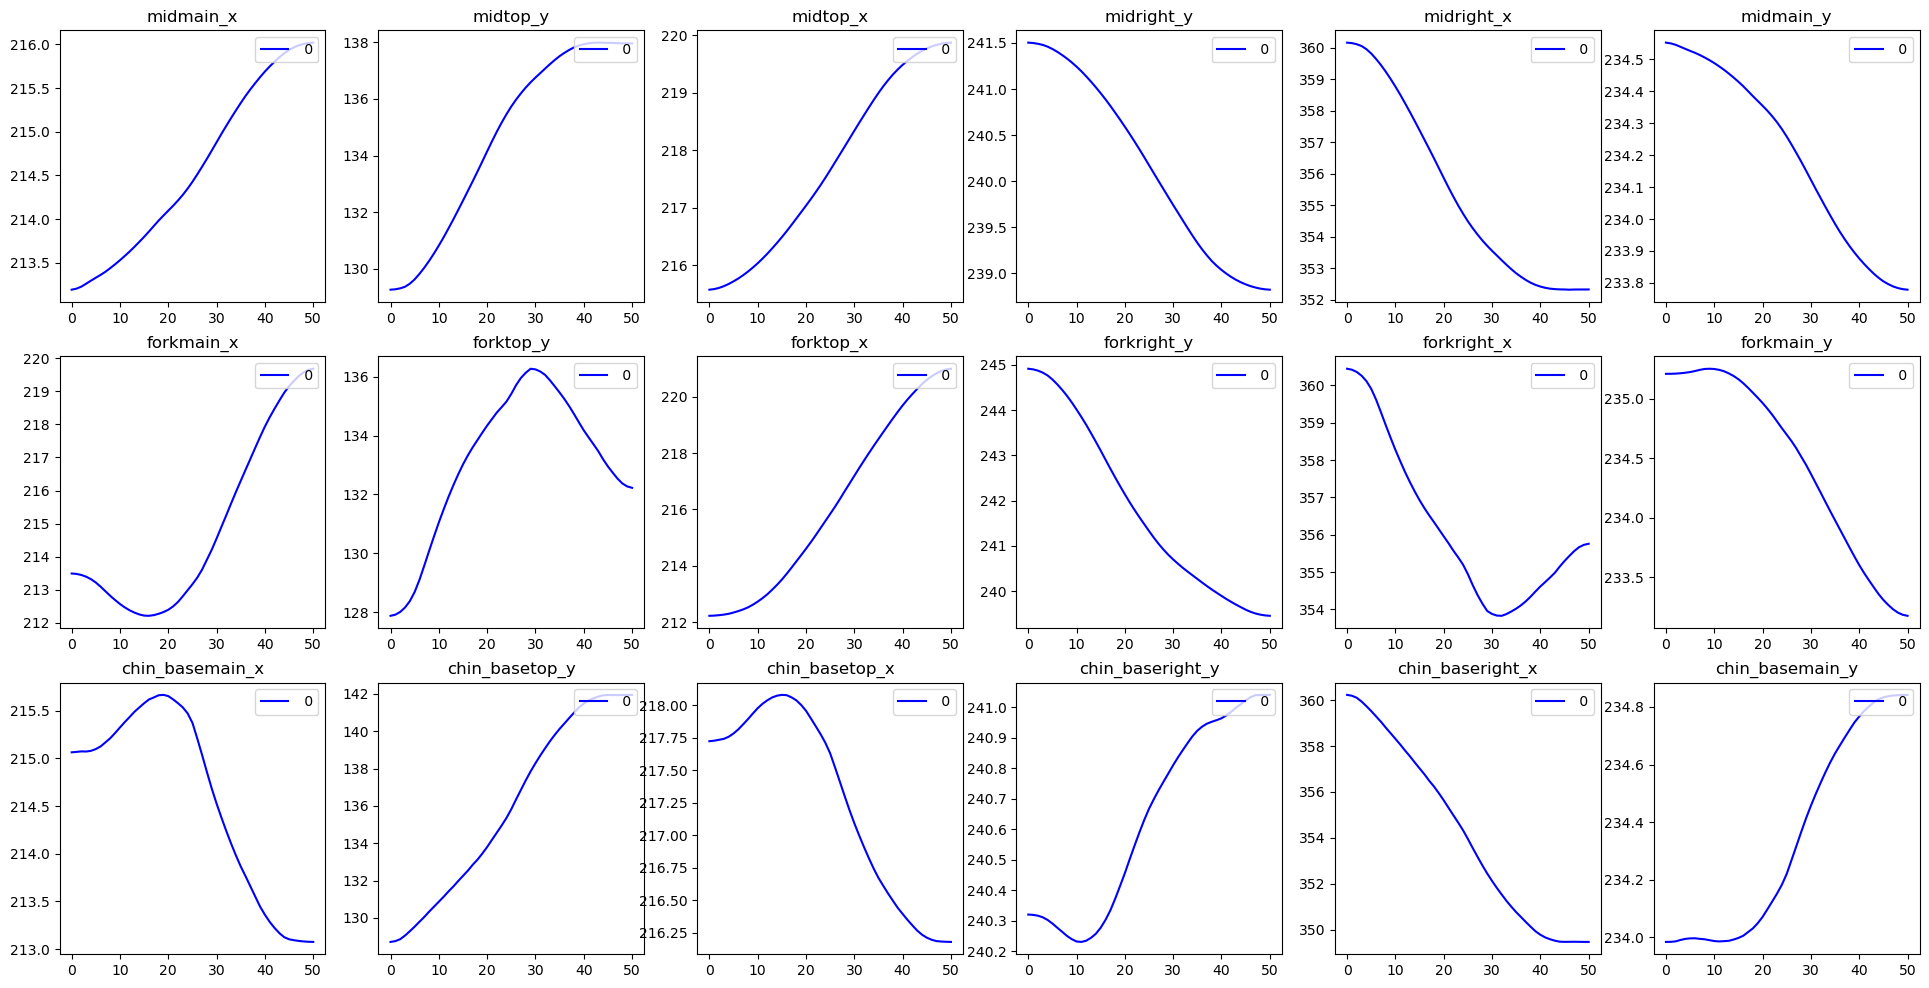

In [48]:
nkeys = len(keypoint_ensemble_list)
ncams = len(camkeys)
color = ['b','g','r','c','m','y','k']
fig,ax = plt.subplots(nkeys,2*ncams,figsize=(24,12))
for n,key in enumerate(keypoint_ensemble_list):
    for j,cam in enumerate(camkeys):
        ax[n, 2*j].plot(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"], color=color[0], label = ' {}'.format(mu[0]))
        ax[n,2*j].title.set_text('{}'.format(key)+'{}'.format(cam)+'_x')

        ax[n, 2*j-1].plot(all_mu[0]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"], color=color[0], label = ' {}'.format(mu[0]))
        ax[n, 2*j-1].title.set_text('{}'.format(key)+'{}'.format(cam)+'_y')
        ax[n, 2*j].legend(loc='upper right')
        ax[n,2*j-1].legend(loc='upper right')
        

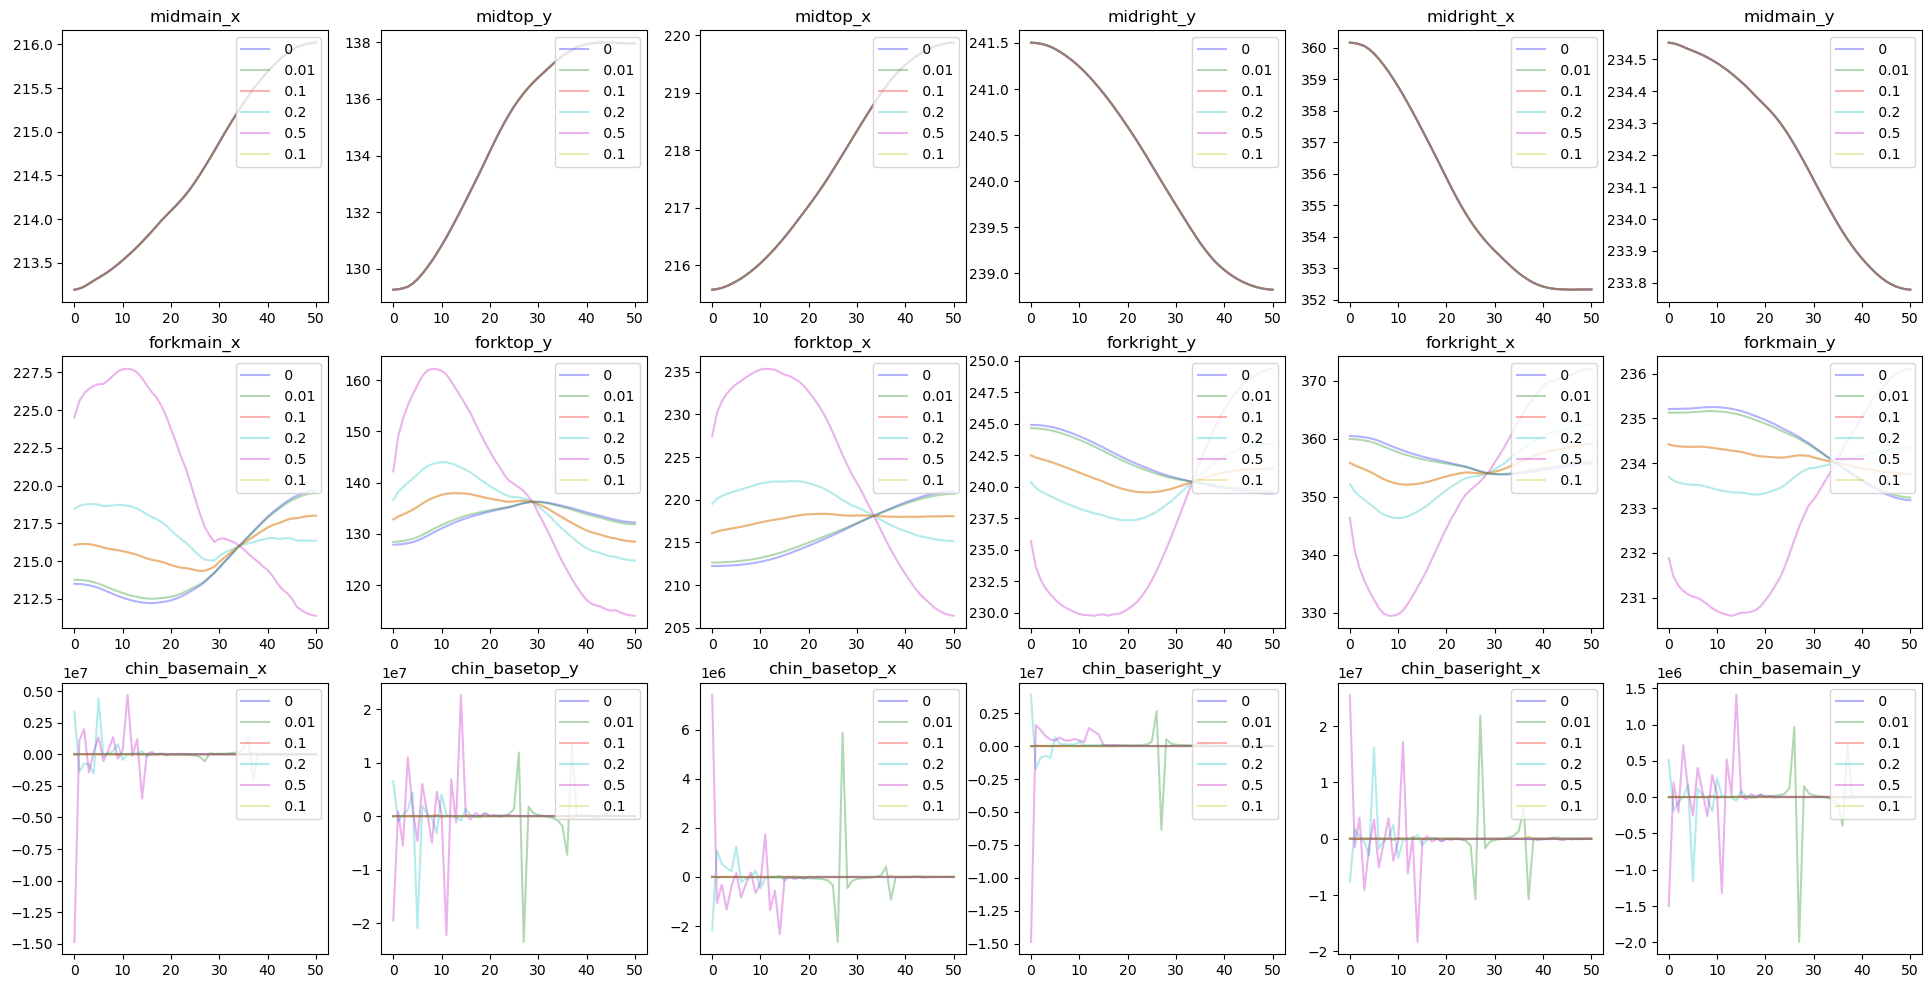

In [38]:
nkeys = len(keypoint_ensemble_list)
ncams = len(camkeys)
color = ['b','g','r','c','m','y','k']
fig,ax = plt.subplots(nkeys,2*ncams,figsize=(24,12))
for n,key in enumerate(keypoint_ensemble_list):
    for j,cam in enumerate(camkeys):
        for i in range(len(mu)):
            ax[n, 2*j].plot(all_mu[i]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["x"], color=color[i], label = ' {}'.format(mu[i]), alpha=0.3)
            ax[n,2*j].title.set_text('{}'.format(key)+'{}'.format(cam)+'_x')

            ax[n, 2*j-1].plot(all_mu[i]['{}_df'.format(cam)]['ensemble-kalman_tracker'][key]["y"], color=color[i], label = ' {}'.format(mu[i]), alpha = 0.3)
            ax[n, 2*j-1].title.set_text('{}'.format(key)+'{}'.format(cam)+'_y')
            ax[n, 2*j].legend(loc='upper right')
            ax[n,2*j-1].legend(loc='upper right')
        